<center><font size = "10"> Week 10 - Network Stimulation<center>
<center><font size = "8">Home Work <center>

In [90]:
!nrnivmodl 

/home/in_silico/InSilicoClass/my_notebooks/week10
vecevent.mod
vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: gcc -shared  -fPIC -DPIC  .libs/vecevent.o .libs/mod_func.o   -Wl,-rpat

In [91]:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(seed=2)

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

In [92]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [93]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return [netcon, source.type, target.type]

In [94]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time

# Ex1. Regular synchronous stimulation. Half weight connection.

<font size='3'>Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials. Connect the cells with weight = 1, as it is done in tutorial 01. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. Create a regular synchronous stimulation and apply it to each exponential synapse. Run a simulation of 300 ms and show the plots for the voltage and the spikes.

<font size='3'>1. Reduce the weigth connection between cells to 0.5, plot the same result as before and compare with the previous simulation. What do you see now? Explain.
    
<font size='3'>2. Reduce the weight connection of the expenential synapses to 0.5, plot the result and compare it with the first simulation (weight connection between cells = 1). What do you see? Explain [2 pts]

In [95]:
!pwd

/home/in_silico/InSilicoClass/my_notebooks/week10


In [96]:
path = '../week7'
i1 = Cell(path+'/morphs/morph_08.swc', 'morph_8', 'inhibitory')
i2 = Cell(path+'/morphs/morph_04.swc', 'morph_4', 'inhibitory')

e1 = Cell(path+'/morphs/morph_02.swc', 'morph_2', 'excitatory')
e2 = Cell(path+'/morphs/morph_09.swc', 'morph_9', 'excitatory')
e3 = Cell(path+'/morphs/morph_10.swc', 'morph_10', 'excitatory')

error ../week7/morphs/morph_08.swc line 14319: could not parse: 
error ../week7/morphs/morph_04.swc line 6922: could not parse: 
error ../week7/morphs/morph_02.swc line 36377: could not parse: 
error ../week7/morphs/morph_09.swc line 13198: could not parse: 
error ../week7/morphs/morph_10.swc line 18854: could not parse: 


In [97]:
cells_Pyr = [e1, e2, e3]
cells_Int = [i1, i2]
cells = cells_Pyr + cells_Int

In [98]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

morph_2: 15 apical sections, 12 basal sections, 2 soma sections and 219 axon senctions
morph_9: 7 apical sections, 49 basal sections, 2 soma sections and 115 axon senctions
morph_10: 15 apical sections, 24 basal sections, 2 soma sections and 271 axon senctions
morph_8: 45 basal sections, 2 soma sections and 466 axon senctions
morph_4: 43 basal sections, 2 soma sections and 133 axon senctions


In [99]:
netcons = []

for i,source in enumerate(cells):
    for j,target in enumerate(cells):
        if i==j:
            continue
        if source.type == 'inhibitory':
            nc = connect(source,target,weight = 1.0, target_neurite='soma')
        else:
            nc = connect(source,target,weight = 1.0)
        netcons.append(nc)

Connected cells morph_2 -> morph_9 with weight 1 and delay 5, from axon[57] to dend[41]
Connected cells morph_2 -> morph_10 with weight 1 and delay 5, from axon[65] to dend[2]
Connected cells morph_2 -> morph_8 with weight 1 and delay 5, from axon[178] to dend[18]
Connected cells morph_2 -> morph_4 with weight 1 and delay 5, from axon[20] to dend[19]
Connected cells morph_9 -> morph_2 with weight 1 and delay 5, from axon[69] to dend[4]
Connected cells morph_9 -> morph_10 with weight 1 and delay 5, from axon[83] to dend[19]
Connected cells morph_9 -> morph_8 with weight 1 and delay 5, from axon[21] to dend[44]
Connected cells morph_9 -> morph_4 with weight 1 and delay 5, from axon[6] to dend[37]
Connected cells morph_10 -> morph_2 with weight 1 and delay 5, from axon[74] to dend[6]
Connected cells morph_10 -> morph_9 with weight 1 and delay 5, from axon[178] to dend[9]
Connected cells morph_10 -> morph_8 with weight 1 and delay 5, from axon[152] to dend[13]
Connected cells morph_10 -> m

In [100]:
import random

In [101]:
random.seed(1)

In [102]:
# Stimulator
stimulator = h.VecStim()
spike_times = [20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

Expo_synapse_netcons = []

synapses = []

for cell in cells:
    rand_sec_num = random.randint(0, len(cell.dend)-1)
    synapse = h.ExpSyn(cell.dend[rand_sec_num](0.5))
    synapse.tau = 2
    connection = h.NetCon(stimulator, synapse)
    connection.weight[0] = 1.0
    synapses.append(synapse)
    Expo_synapse_netcons.append(connection)

In [103]:
v_traces = []
for cell in cells:
    v_trace = h.Vector().record(cell.soma[0](0.5)._ref_v)
    v_traces.append(v_trace)
    
time = h.Vector().record(h._ref_t)

In [104]:
h.finitialize(-65)
h.continuerun(300)

0.0

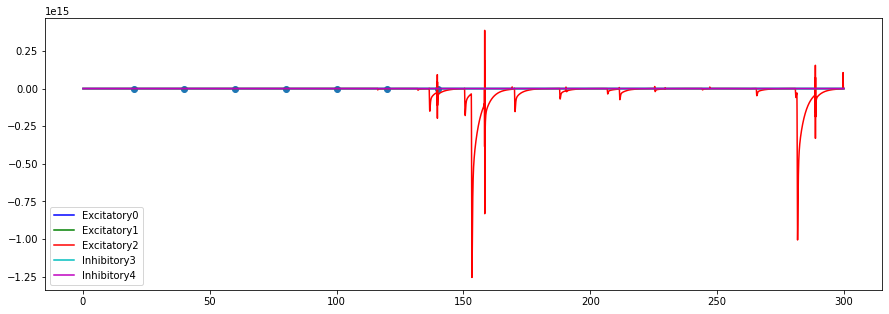

In [153]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(15,5))
for idx, v in enumerate(v_traces):
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
        
plt.scatter(spike_times,np.zeros_like(spike_times)-80)
plt.legend()
plt.show()

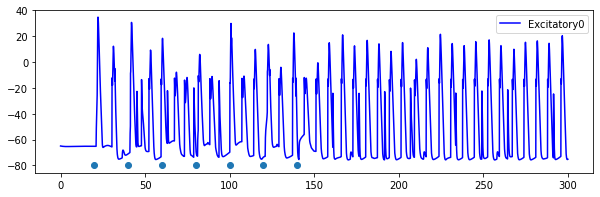

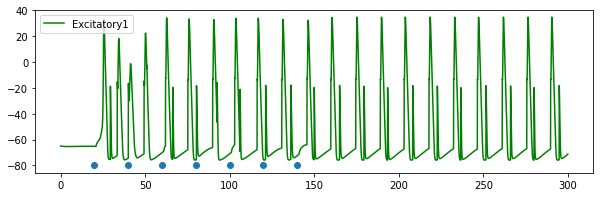

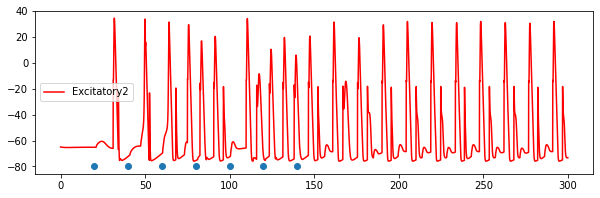

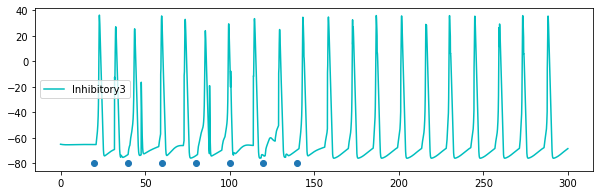

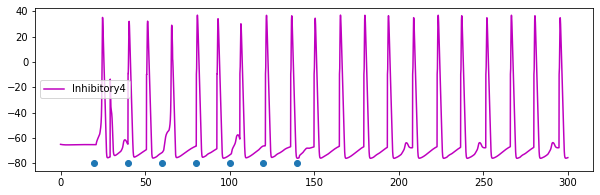

In [106]:
# plot in seperate plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for idx, v in enumerate(v_traces):
    plt.figure(figsize=(10,3))
    plt.scatter(spike_times,np.zeros_like(spike_times)-80)
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
    plt.legend()

plt.show()


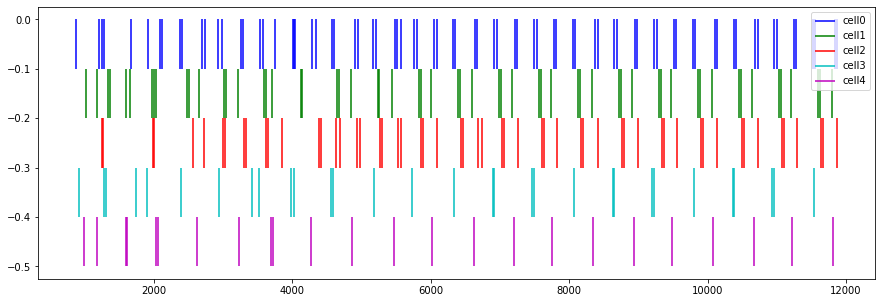

In [107]:
# spike plot
plt.figure(figsize=(15,5))
base =0
for idx, v in enumerate(v_traces):
    spikes = spike_detector(v, -20.0)
    plt.vlines(spikes, ymin=-0.1*idx, ymax=-0.1*(idx+1), color=colors[idx], label='cell%d'%idx)
    plt.legend()
plt.show()


In [108]:
# Q1

inter_cell_weight = 0.5

for connection in netcons:
    connection[0].weight[0] = inter_cell_weight

In [109]:
h.finitialize(-65)
h.continuerun(300)

0.0

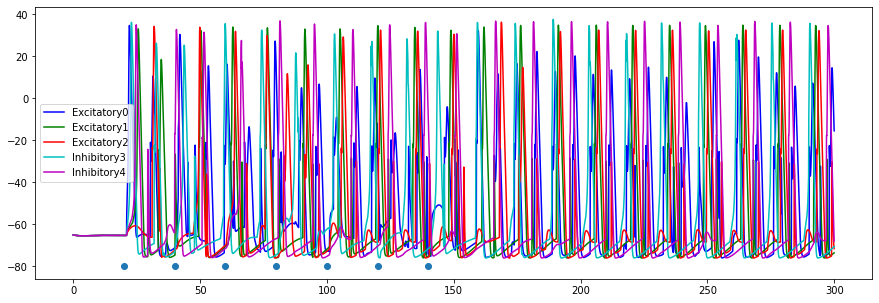

In [110]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(15,5))
for idx, v in enumerate(v_traces):
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
        
plt.scatter(spike_times,np.zeros_like(spike_times)-80)
plt.legend()
plt.show()

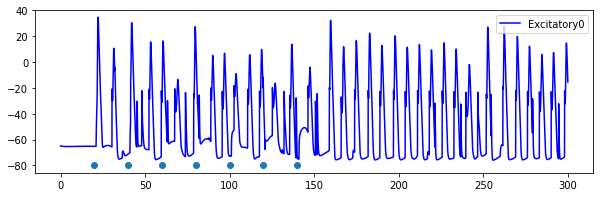

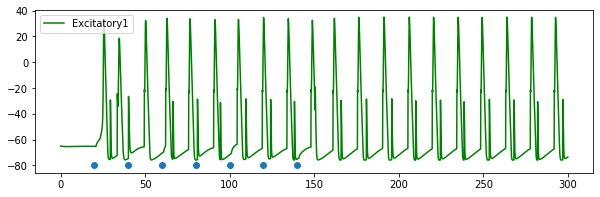

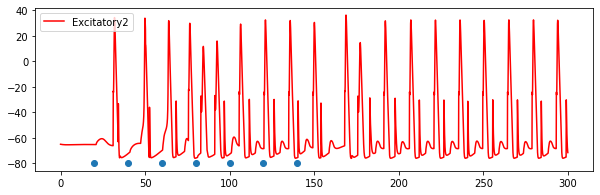

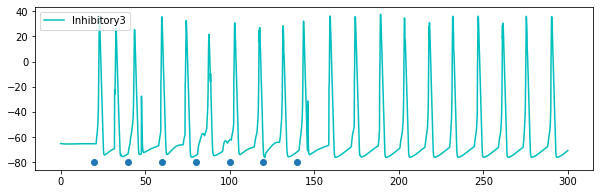

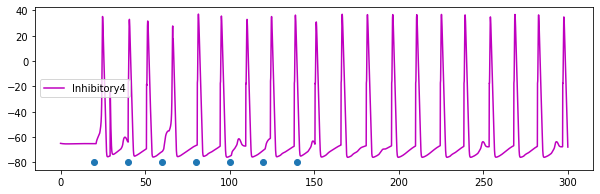

In [111]:
# plot in seperate plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for idx, v in enumerate(v_traces):
    plt.figure(figsize=(10,3))
    plt.scatter(spike_times,np.zeros_like(spike_times)-80)
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
    plt.legend()

plt.show()

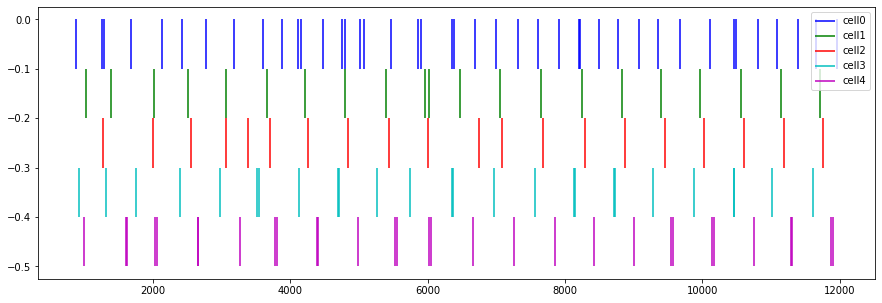

In [112]:
# spike plot
plt.figure(figsize=(15,5))
base =0
for idx, v in enumerate(v_traces):
    spikes = spike_detector(v, -20.0)
    plt.vlines(spikes, ymin=-0.1*idx, ymax=-0.1*(idx+1), color=colors[idx], label='cell%d'%idx)
    plt.legend()
plt.show()

## Answer:
now we see a much more regular activity. specially looking at the excitatory cell 2 (green) we see that after the stimulation it keeps firing regularly (the same voltage pattern) this also applies to other cells. But in the previous stimulation (cell wights = 1) the activity was much more chaotic especially for excitatory cells. Also in this simulation we see that the voltages after stimulation converge to a stable state (firing regularly) but this was not the case before.

In [113]:
# Q2
inter_cell_weight = 1.0

for connection in netcons:
    connection[0].weight[0] = inter_cell_weight
    
expo_syn_weight = 0.5

for connection in Expo_synapse_netcons:
    connection.weight[0] = expo_syn_weight

In [114]:
h.finitialize(-65)
h.continuerun(300)

0.0

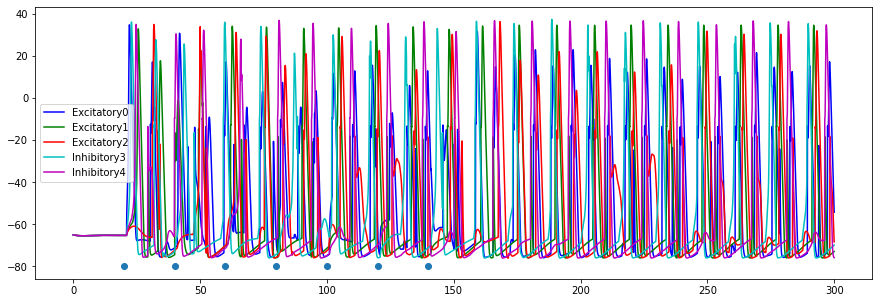

In [115]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(15,5))
for idx, v in enumerate(v_traces):
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
        
plt.scatter(spike_times,np.zeros_like(spike_times)-80)
plt.legend()
plt.show()

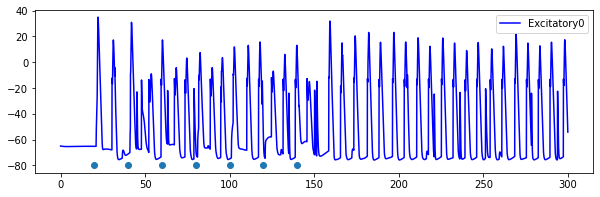

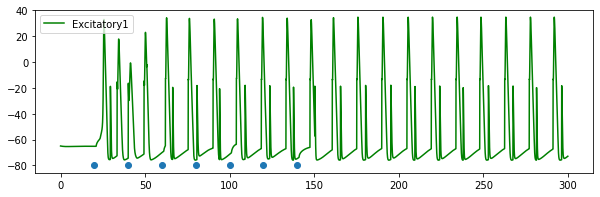

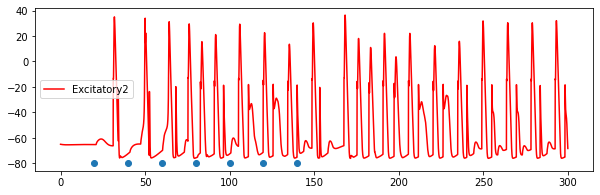

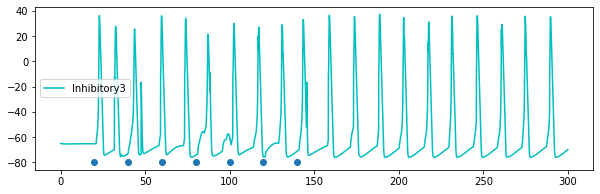

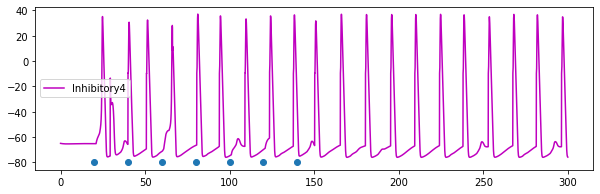

In [116]:
# plot in seperate plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for idx, v in enumerate(v_traces):
    plt.figure(figsize=(10,3))
    plt.scatter(spike_times,np.zeros_like(spike_times)-80)
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
    plt.legend()

plt.show()

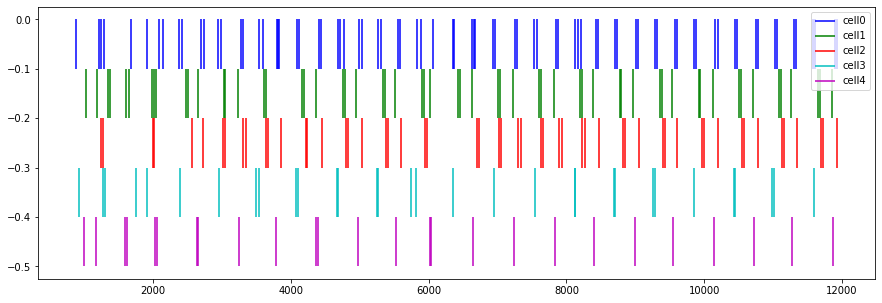

In [117]:
# spike plot
plt.figure(figsize=(15,5))
base =0
for idx, v in enumerate(v_traces):
    spikes = spike_detector(v, -20.0)
    plt.vlines(spikes, ymin=-0.1*idx, ymax=-0.1*(idx+1), color=colors[idx], label='cell%d'%idx)
    plt.legend()
plt.show()

## Answer:
it seems we get an exact replica of the first simulation most probably because ????????????????????????????????????????????????

# Ex2. Irregular asynchrounous stimulation. Inhibitory cells effect = negative weight. 

<font size='3'>Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials. Connect the cells with the following weights: w(Pyr - Pyr) = 1, w(Pyr - Int) = 1, w(Inh - Pyr) = -0.01, w(Int - Int) = -0.01. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. Create a irregular asynchronous stimulation, as it is done in tutorial 02 and apply it to each exponential synapse. Run a simulation that last at least to contain the last stimulation. Plot the results in two plots one showing the cells voltage response and other with the spike detection. Could you describe what do you see? What is the firing dynamics of these small network?
    
<font size='3'>Change the connection weight between Int - Pyr and to - 1 and compare with the previous simulation. Describe what is happening now. [1 pt] 

In [119]:
weights = {'excitatory':{'excitatory':1,'inhibitory':1} ,
           'inhibitory': {'excitatory':-0.01,'inhibitory':-0.01}
           }

for connection in netcons:
    w = weights[connection[1]][connection[2]]
    connection[0].weight[0] = w

In [130]:
random.seed(3)
expo_syn_weight = 1.0
new_expo_synp_netcons = []
all_stims = []
for idx, cell in enumerate(cells):
    # make random stimulations
    stim_times = [20.0]
    for t in range(1, 7):
        n = random.randint(10.0,50.0)
        step = stim_times[t-1] + n
        stim_times.append(step)
    
    all_stims.append(stim_times)
    
    # run the stimulation
    stimulator = h.VecStim()
    spikes_vector = h.Vector(stim_times)
    stimulator.play(spikes_vector)
    
    # add the  connection
    connection = h.NetCon(stimulator, synapses[idx])
    connection.weight[0] = 1.0  
    new_expo_synp_netcons.append(connection)
    

In [138]:
h.finitialize(-65)
h.continuerun(300)

0.0

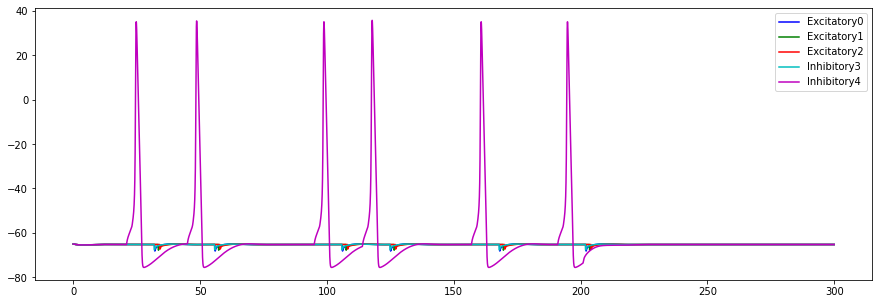

In [139]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(15,5))
for idx, v in enumerate(v_traces):
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
        
plt.legend()
plt.show()

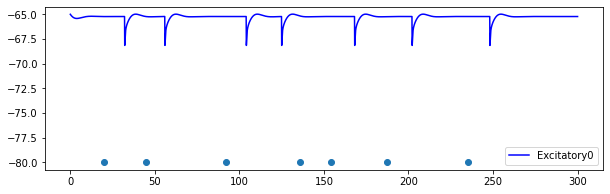

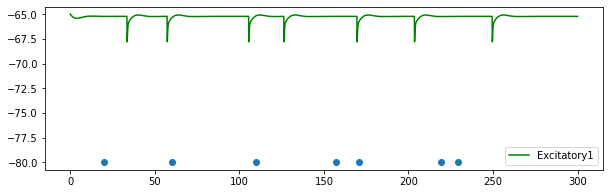

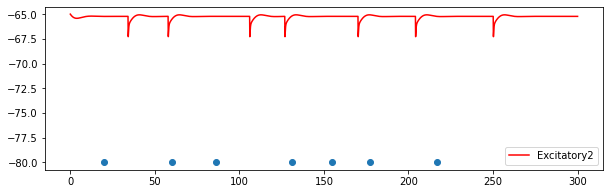

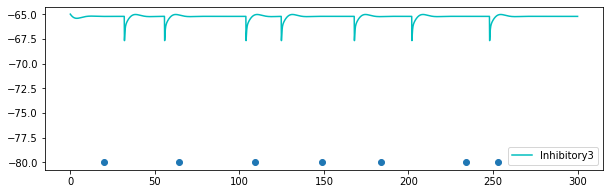

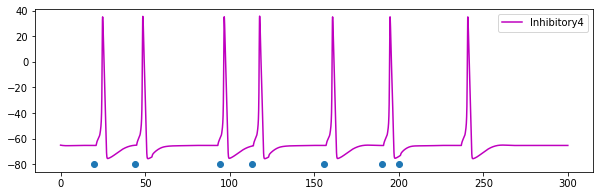

In [133]:
# plot in seperate plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for idx, v in enumerate(v_traces):
    plt.figure(figsize=(10,3))
    plt.scatter(all_stims[idx],np.zeros_like(spike_times)-80)
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
    plt.legend()

plt.show()

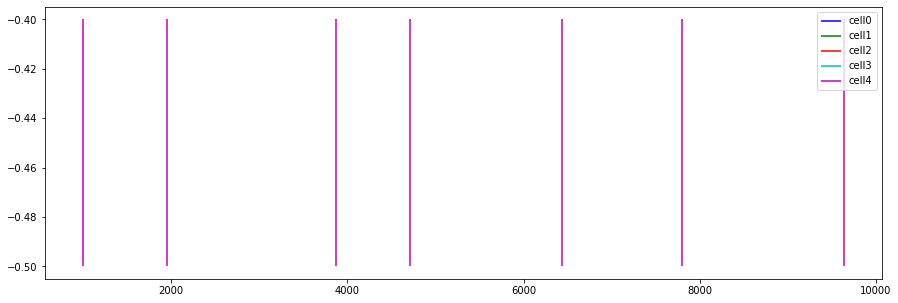

In [135]:
# spike plot
plt.figure(figsize=(15,5))
base =0
for idx, v in enumerate(v_traces):
    spikes = spike_detector(v, -20.0)
    plt.vlines(spikes, ymin=-0.1*idx, ymax=-0.1*(idx+1), color=colors[idx], label='cell%d'%idx)
    plt.legend()
plt.show()

## Answer:
The inhibitory neuron neuron 4 is dominating the others by firing and supressing others. and after the stimulation are done the whole network goes silent.

In [167]:
weights = {'excitatory':{'excitatory':1,'inhibitory':1} ,
           'inhibitory': {'excitatory':-1,'inhibitory':-0.01}
           }

for connection in netcons:
    w = weights[connection[1]][connection[2]]
    connection[0].weight[0] = w

In [168]:
h.finitialize(-65)
h.continuerun(300)

0.0

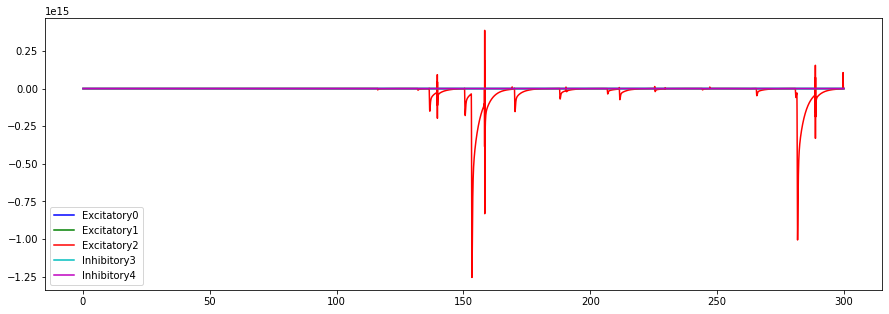

In [169]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(15,5))
for idx, v in enumerate(v_traces):
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
        
plt.legend()
plt.show()

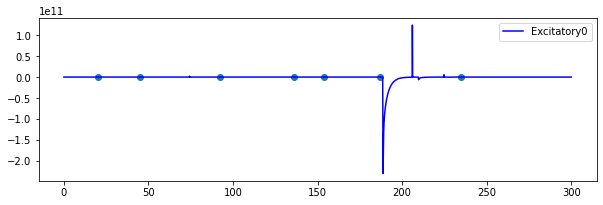

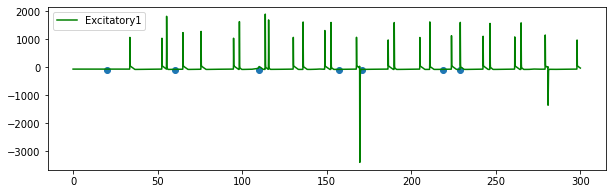

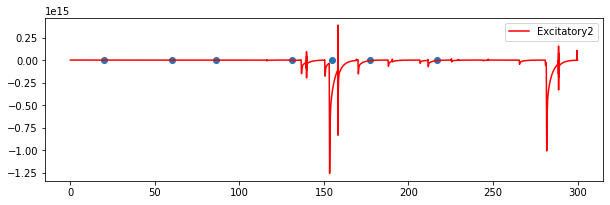

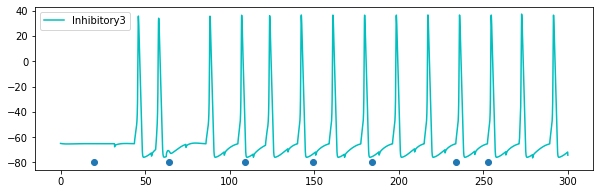

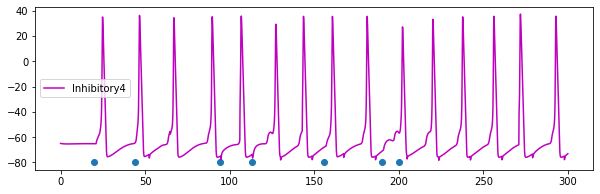

In [170]:
# plot in seperate plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for idx, v in enumerate(v_traces):
    plt.figure(figsize=(10,3))
    plt.scatter(all_stims[idx],np.zeros_like(spike_times)-80)
    if idx<=2:
        plt.plot(time, v, label='Excitatory%d'%idx, color=colors[idx])
    else:
        plt.plot(time, v, label='Inhibitory%d'%idx, color=colors[idx])
    plt.legend()

plt.show()

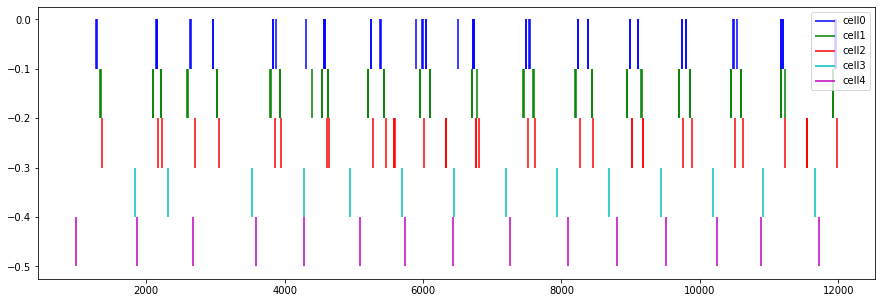

In [171]:
# spike plot
plt.figure(figsize=(15,5))
base =0
for idx, v in enumerate(v_traces):
    spikes = spike_detector(v, -20.0)
    plt.vlines(spikes, ymin=-0.1*idx, ymax=-0.1*(idx+1), color=colors[idx], label='cell%d'%idx)
    plt.legend()
plt.show()

## Answer:
here we see that in the case of excitatory cells the network goes out of control ?! the scales are not reasonable !! we should have less activity but somehow we have more ?!

# Ex3. Remove inhibitory cells

<font size='3'> Perform the same simulation as before, but this time remove the inhibitory cells from the network. Compare this result with the previous simulations. What is the role of the inhibitory cells in this small network? [1 pt]

# Ex4. Poissonian stimulation

<font size='3'>Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials. Connect the cells with the following weights: w(Pyr - Pyr) = 1, w(Pyr - Int) = 1, w(Inh - Pyr) = -0.01, w(Int - Int) = -0.01. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. Using the function (numpy.ramdom.poisson()) create a poissonian stimulation process different for each exponential synapse with no more than 10 stimulations. Run a simulation that last at least to contain the last stimulation. Plot the voltage response of each cell and the spike detection.
    
    
<font size='3'>Describe what do you see. What do you think a poissonian stimulation is useful for when simulationg networks? Is there any difference bewteen a poissonian stimulation and an irregular asynchronous stimualtion? [2 pts]

<font size='3'><font color='red'>__IMPORTANT!!__ The code from the tutorials generates random connections between cells, if you want to compare results you have to keep the same connections (same axon section connected to same basal section) between the cells. The same happens with the location of the exponential synapses.